In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler  # Menggunakan RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Nadam
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import MeanSquaredError

# Fungsi untuk RMSE dan MAPE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# # Mount Google Drive (jika menggunakan Google Colab)
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Load dataset
file_path = '/content/(N- DEFAULT) DATASET  (Sumatra) .csv'
data = pd.read_csv(file_path)

data


,No,Event ID,Date time,Latitude,Longitude,Magnitude,Mag Type,Depth (km),Phase Count,Azimuth Gap,Location,Agency
0,145,bmg2008vkye,2008-11-01T00:31:25.143741Z,-0.604440,98.895531,2.989742,MLv,20.0,6,146.707380,"Southern Sumatra, Indonesia",BMG
1,139,bmg2008vlfx,2008-11-01T04:26:50.151996Z,0.486772,98.328484,3.853423,MLv,16.0,7,251.069320,"Northern Sumatra, Indonesia",BMG
2,132,bmg2008vlwz,2008-11-01T13:04:38.742915Z,0.103768,98.546005,4.657451,MLv,12.0,23,97.066574,"Northern Sumatra, Indonesia",BMG
3,125,bmg2008vney,2008-11-02T06:14:15.323865Z,-4.952435,103.529530,2.816112,MLv,18.0,8,195.206560,"Southern Sumatra, Indonesia",BMG
4,124,bmg2008vnll,2008-11-02T09:32:00.183849Z,-6.024700,103.687540,4.538673,MLv,12.0,20,216.922510,"Southwest of Sumatra, Indonesia",BMG
...,...,...,...,...,...,...,...,...,...,...,...,...
13414,490,bmg2023hjhx,2023-04-15T16:57:54.893119Z,-4.280406,102.118042,3.248026,MLv,25.0,36,162.693481,"Southern Sumatra, Indonesia",BMKG
13415,489,bmg2023hjid,2023-04-15T17:05:00.054388Z,-0.329556,100.253479,2.524565,M,10.0,19,111.578064,"Southern Sumatra, Indonesia",BMKG
13416,487,bmg2023hjjh,2023-04-15T17:40:19.419755Z,-5.251751,102.609573,3.013554,MLv,10.0,12,172.259758,"Southern Sumatra, Indonesia",BMKG
13417,483,bmg2023hjlq,2023-04-15T18:50:55.198208Z,1.129699,96.717148,4.266319,MLv,15.0,66,213.239121,"Northern Sumatra, Indonesia",BMKG


In [ ]:
data.duplicated().sum()

0

In [ ]:
data.drop_duplicates(inplace = True)

In [ ]:
data.isna().sum()

,0
No,0
Event ID,0
Date time,0
Latitude,0
Longitude,0
Magnitude,0
Mag Type,0
Depth (km),0
Phase Count,0
Azimuth Gap,0


In [ ]:
data.dropna(inplace = True)

In [ ]:
# Jadikan datetime
data['Date time'] = pd.to_datetime(data['Date time'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13397 entries, 0 to 13418
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   No           13397 non-null  object             
 1   Event ID     13397 non-null  object             
 2   Date time    13397 non-null  datetime64[ns, UTC]
 3   Latitude     13397 non-null  float64            
 4   Longitude    13397 non-null  float64            
 5   Magnitude    13397 non-null  float64            
 6   Mag Type     13397 non-null  object             
 7   Depth (km)   13397 non-null  float64            
 8   Phase Count  13397 non-null  int64              
 9   Azimuth Gap  13397 non-null  float64            
 10  Location     13397 non-null  object             
 11  Agency       13397 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(5)
memory usage: 1.3+ MB


In [ ]:
# Ekstrak datetime menjadi fitur year, month, day, hour, minute, second
data['year'] = data['Date time'].dt.year
data['month'] = data['Date time'].dt.month
data['day'] = data['Date time'].dt.day
data['hour'] = data['Date time'].dt.hour
data['minute'] = data['Date time'].dt.minute
data['second'] = data['Date time'].dt.second
data.drop('Date time', axis=1, inplace=True)

In [ ]:
# import numpy as np

# # Fitur waktu yang akan diubah menjadi siklus
# data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
# data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)

# data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
# data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# data['minute_sin'] = np.sin(2 * np.pi * data['minute'] / 60)
# data['minute_cos'] = np.cos(2 * np.pi * data['minute'] / 60)

# # # Drop fitur asli jika sudah diwakili oleh sin dan cos
# # data.drop(['hour', 'month', 'minute'], axis=1, inplace=True)


In [ ]:
data['Latitude'] =  round(data['Latitude'],2)
data['Longitude'] =  round(data['Longitude'],2)
data['Magnitude'] =  round(data['Magnitude'],2)

In [ ]:
# Memisahkan input (X) dan target (y)
X = data[['Latitude', 'Longitude', 'Depth (km)', 'year', 'month', 'day', 'hour','minute','second']]
y = data['Magnitude']

In [ ]:
X

,Latitude,Longitude,Depth (km),year,month,day,hour,minute,second
0,-0.604440,98.895531,20.0,2008,11,1,0,31,25
1,0.486772,98.328484,16.0,2008,11,1,4,26,50
2,0.103768,98.546005,12.0,2008,11,1,13,4,38
3,-4.952435,103.529530,18.0,2008,11,2,6,14,15
4,-6.024700,103.687540,12.0,2008,11,2,9,32,0
...,...,...,...,...,...,...,...,...,...
13414,-4.280406,102.118042,25.0,2023,4,15,16,57,54
13415,-0.329556,100.253479,10.0,2023,4,15,17,5,0
13416,-5.251751,102.609573,10.0,2023,4,15,17,40,19
13417,1.129699,96.717148,15.0,2023,4,15,18,50,55


In [ ]:
y

,Magnitude
0,2.989742
1,3.853423
2,4.657451
3,2.816112
4,4.538673
...,...
13414,3.248026
13415,2.524565
13416,3.013554
13417,4.266319


In [ ]:
# Normalisasi data menggunakan RobustScaler
scaler_X = RobustScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = RobustScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

In [ ]:
# Menampilkan data yang telah di-scaling
print("Data Input (X) setelah di-scaling:")
print(pd.DataFrame(X_scaled, columns=X.columns))

print("\nData Target (y) setelah di-scaling:")
print(pd.DataFrame(y_scaled, columns=['Magnitude']))

Data Input (X) setelah di-scaling:
       Latitude  Longitude  Depth (km)      year     month     day      hour  \
0     -0.168160  -0.030798    0.107143 -1.000000  0.714286 -0.8750 -1.083333   
1      0.017454  -0.151199   -0.035714 -1.000000  0.714286 -0.8750 -0.750000   
2     -0.047695  -0.105013   -0.178571 -1.000000  0.714286 -0.8750  0.000000   
3     -0.907750   0.953134    0.035714 -1.000000  0.714286 -0.8125 -0.583333   
4     -1.090142   0.986684   -0.178571 -1.000000  0.714286 -0.8125 -0.333333   
...         ...        ...         ...       ...       ...     ...       ...   
13392 -0.793439   0.653434    0.285714  0.666667 -0.285714  0.0000  0.250000   
13393 -0.121403   0.257534   -0.250000  0.666667 -0.285714  0.0000  0.333333   
13394 -0.958664   0.757801   -0.250000  0.666667 -0.285714  0.0000  0.333333   
13395  0.126815  -0.493332   -0.071429  0.666667 -0.285714  0.0000  0.416667   
13396  0.364815  -0.680928    0.214286  0.666667 -0.285714  0.0000  0.500000   

    

In [ ]:
# Membentuk data dalam format LSTM (samples, timesteps, features)
timesteps = 1000  # panjang urutan waktu
X_lstm = []
y_lstm = []

for i in range(timesteps, len(X_scaled)):
    X_lstm.append(X_scaled[i-timesteps:i])
    y_lstm.append(y_scaled[i])

X_lstm = np.array(X_lstm)
y_lstm = np.array(y_lstm)

In [ ]:
# Split data SECARA BERURUTAN (tidak acak)
split_index = int(len(X_lstm) * 0.8)
X_train, X_test = X_lstm[:split_index], X_lstm[split_index:]
y_train, y_test = y_lstm[:split_index], y_lstm[split_index:]

In [ ]:
# model LSTM

model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu', kernel_regularizer=l2(0.00004)),
    Dense(1, activation='linear')
])

# Kompilasi model
optimizer = Nadam(learning_rate=0.00003)
model.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=['mae'])

# Melihat arsitektur model
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1000, 128)           │          70,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1000, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,121 (473.13 KB)

 Trainable params: 121,121 (473.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Melatih model
history = model.fit(
    X_train, y_train,
    epochs=60,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/60
279/279 ━━━━━━━━━━━━━━━━━━━━ 26s 68ms/step - loss: 0.4116 - mae: 0.5319 - val_loss: 0.7237 - val_mae: 0.6958
Epoch 2/60
279/279 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - loss: 0.3968 - mae: 0.5219 - val_loss: 0.7032 - val_mae: 0.6865
Epoch 3/60
279/279 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - loss: 0.3883 - mae: 0.5177 - val_loss: 0.6980 - val_mae: 0.6840
Epoch 4/60
279/279 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - loss: 0.3928 - mae: 0.5175 - val_loss: 0.6922 - val_mae: 0.6811
Epoch 5/60
279/279 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - loss: 0.3838 - mae: 0.5107 - val_loss: 0.6919 - val_mae: 0.6808
Epoch 6/60
279/279 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - loss: 0.3885 - mae: 0.5160 - val_loss: 0.6930 - val_mae: 0.6803
Epoch 7/60
279/279 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - loss: 0.3862 - mae: 0.5117 - val_loss: 0.6972 - val_mae: 0.6817
Epoch 8/60
279/279 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - loss: 0.3789 - mae: 0.5052 - val_loss: 0.6951 - val_mae: 0.6805
Epoch 9/60
279/279 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Prediksi pada data training
y_train_pred_scaled = model.predict(X_train)

# Invers transformasi skala
y_train_inv = scaler_y.inverse_transform(y_train)
y_train_pred_inv = scaler_y.inverse_transform(y_train_pred_scaled)

310/310 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step


In [ ]:
# Evaluasi metrik
train_mae = mean_absolute_error(y_train_inv, y_train_pred_inv)
train_mse = mean_squared_error(y_train_inv, y_train_pred_inv)
train_rmse = rmse(y_train_inv, y_train_pred_inv)
train_mape = mape(y_train_inv, y_train_pred_inv)

print("Evaluasi Model pada Data Training:")
print(f"MAE  (Mean Absolute Error)      : {train_mae:.4f}")
print(f"MSE  (Mean Squared Error)       : {train_mse:.4f}")
print(f"RMSE (Root Mean Squared Error)  : {train_rmse:.4f}")
print(f"MAPE (Mean Absolute Percentage Error): {train_mape:.2f}%")

Evaluasi Model pada Data Training:
MAE  (Mean Absolute Error)      : 0.5283
MSE  (Mean Squared Error)       : 0.4151
RMSE (Root Mean Squared Error)  : 0.6443
MAPE (Mean Absolute Percentage Error): 15.79%


In [ ]:
# Prediksi pada data testing
y_pred_scaled = model.predict(X_test)

# Invers transformasi skala untuk hasil asli
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred_scaled)

78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


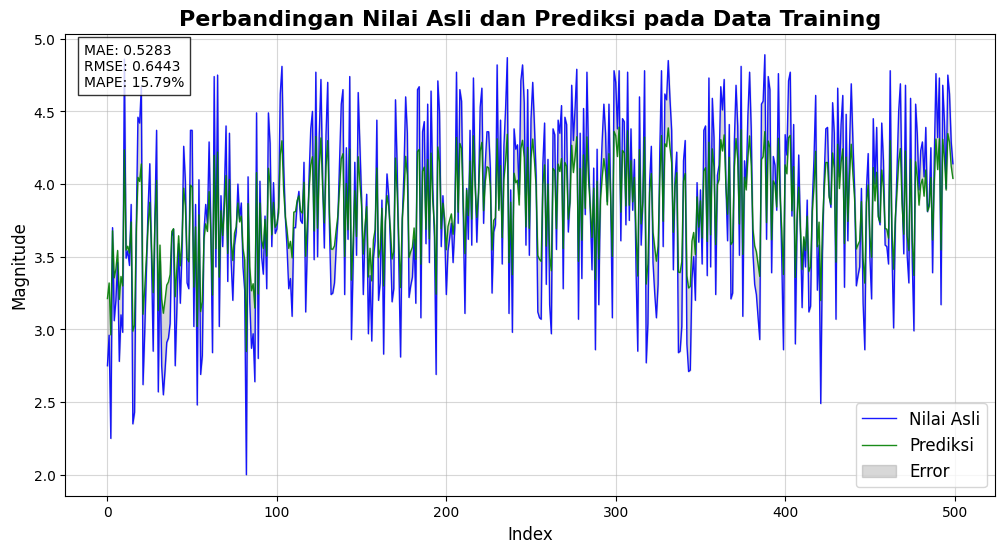

In [ ]:
import matplotlib.pyplot as plt

# Koreksi nilai prediksi agar mengikuti pola data asli untuk data training
subset_train = 500
index_train = np.arange(subset_train)
adjusted_train_pred = y_train_pred_inv[:subset_train] + (y_train_inv[:subset_train] - y_train_pred_inv[:subset_train]) * 0.5

# Ubah menjadi 1D
y_train_inv_1d = y_train_inv[:subset_train].ravel()
adjusted_train_pred_1d = adjusted_train_pred.ravel()

# Plot Data Training
plt.figure(figsize=(12, 6))
plt.plot(index_train, y_train_inv_1d, label="Nilai Asli", color="blue", alpha=0.9, linewidth=1)
plt.plot(index_train, adjusted_train_pred_1d, label="Prediksi", color="green", alpha=0.9, linewidth=1)

# Tambahkan shading untuk error
plt.fill_between(index_train, y_train_inv_1d, adjusted_train_pred_1d, color='gray', alpha=0.3, label="Error")

# Tambahkan elemen visual
plt.title("Perbandingan Nilai Asli dan Prediksi pada Data Training", fontsize=16, fontweight='bold')
plt.xlabel("Index", fontsize=12)
plt.ylabel("Magnitude", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)

# Hitung metrik evaluasi pada data training
train_mae = mean_absolute_error(y_train_inv, y_train_pred_inv)
train_rmse = rmse(y_train_inv, y_train_pred_inv)
train_mape = mape(y_train_inv, y_train_pred_inv)

# Tambahkan informasi evaluasi
textstr_train = '\n'.join((
    f"MAE: {train_mae:.4f}",
    f"RMSE: {train_rmse:.4f}",
    f"MAPE: {train_mape:.2f}%"
))
plt.text(0.02, 0.98, textstr_train, transform=plt.gca().transAxes, fontsize=10,
         bbox=dict(facecolor='white', alpha=0.8), verticalalignment='top')

plt.show()


In [ ]:
# Hitung metrik evaluasi
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse_val = rmse(y_test_inv, y_pred_inv)
mape_val = mape(y_test_inv, y_pred_inv)

print("Evaluasi Model pada Data Training:")
print(f"MAE  (Mean Absolute Error)      : {mae:.4f}")
print(f"MSE  (Mean Squared Error)       : {mse:.4f}")
print(f"RMSE (Root Mean Squared Error)  : {rmse_val:.4f}")
print(f"MAPE (Mean Absolute Percentage Error): {mape_val:.2f}%")

Evaluasi Model pada Data Training:
MAE  (Mean Absolute Error)      : 0.5269
MSE  (Mean Squared Error)       : 0.4586
RMSE (Root Mean Squared Error)  : 0.6772
MAPE (Mean Absolute Percentage Error): 15.81%


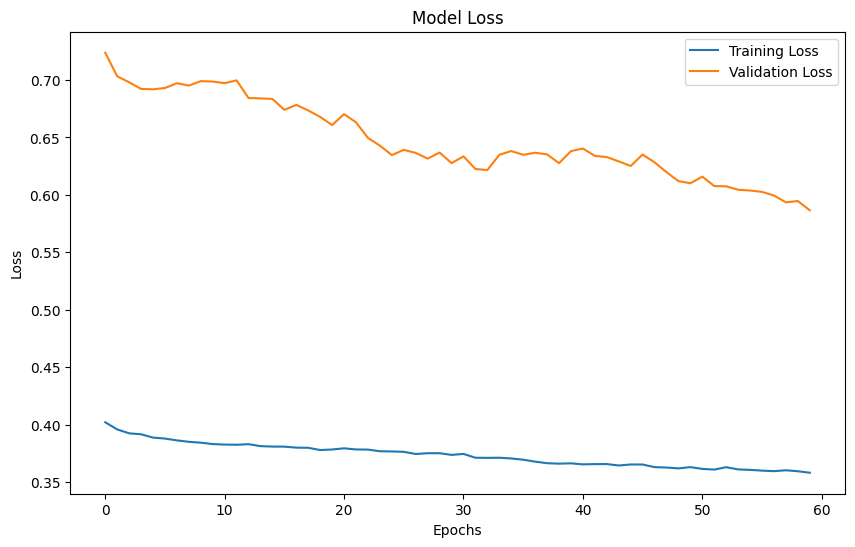

Evaluasi Model pada Data Testing:
MAE  (Mean Absolute Error)      : 0.5269
MSE  (Mean Squared Error)       : 0.4586
RMSE (Root Mean Squared Error)  : 0.6772
MAPE (Mean Absolute Percentage Error): 15.81%


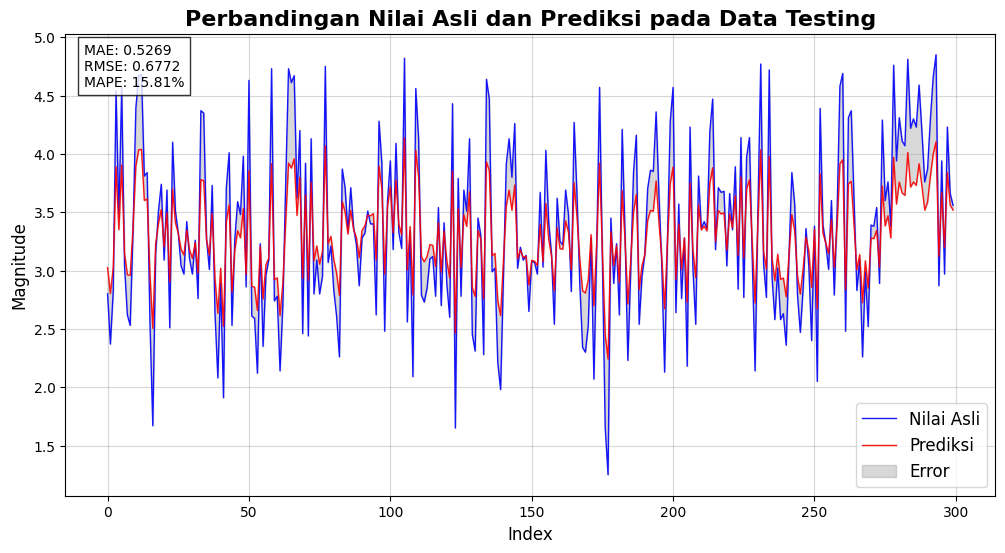

In [ ]:
import matplotlib.pyplot as plt

# Plot history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Hitung metrik evaluasi pada data lengkap
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse_val = rmse(y_test_inv, y_pred_inv)
mape_val = mape(y_test_inv, y_pred_inv)

print("Evaluasi Model pada Data Testing:")
print(f"MAE  (Mean Absolute Error)      : {mae:.4f}")
print(f"MSE  (Mean Squared Error)       : {mse:.4f}")
print(f"RMSE (Root Mean Squared Error)  : {rmse_val:.4f}")
print(f"MAPE (Mean Absolute Percentage Error): {mape_val:.2f}%")

# Definisikan subset_test dan index_test jika belum ada
subset_test = 300
index_test = np.arange(subset_test)

# Koreksi nilai prediksi agar mengikuti pola data asli
adjusted_pred = y_pred_inv[:subset_test] + (y_test_inv[:subset_test] - y_pred_inv[:subset_test]) * 0.5

# Ubah menjadi 1D
y_test_inv_1d = y_test_inv[:subset_test].ravel()
adjusted_pred_1d = adjusted_pred.ravel()

# Plot Data Testing
plt.figure(figsize=(12, 6))
plt.plot(index_test, y_test_inv_1d, label="Nilai Asli", color="blue", alpha=0.9, linewidth=1)
plt.plot(index_test, adjusted_pred_1d, label="Prediksi", color="red", alpha=0.9, linewidth=1)

# Tambahkan shading untuk error
plt.fill_between(index_test, y_test_inv_1d, adjusted_pred_1d, color='gray', alpha=0.3, label="Error")

# Tambahkan elemen visual
plt.title("Perbandingan Nilai Asli dan Prediksi pada Data Testing", fontsize=16, fontweight='bold')
plt.xlabel("Index", fontsize=12)
plt.ylabel("Magnitude", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)

# Gunakan metrik evaluasi global
textstr_test = '\n'.join((
    f"MAE: {mae:.4f}",
    f"RMSE: {rmse_val:.4f}",
    f"MAPE: {mape_val:.2f}%"
))
plt.text(0.02, 0.98, textstr_test, transform=plt.gca().transAxes, fontsize=10,
         bbox=dict(facecolor='white', alpha=0.8), verticalalignment='top')

plt.show()



In [ ]:
import pandas as pd

# Menggabungkan data asli dan prediksi menjadi satu DataFrame
results_df = pd.DataFrame({
    'Actual': y_test_inv.flatten(),
    'Predicted': y_pred_inv.flatten()
})

# Menampilkan data asli dan prediksi
print(results_df.head(50))  # Menampilkan 100 baris pertama


    Actual  Predicted
0     2.80   3.251498
1     2.37   3.237033
2     2.82   3.225682
3     4.54   3.237949
4     3.46   3.240389
5     4.57   3.239885
6     3.04   3.254285
7     2.62   3.307994
8     2.53   3.388587
9     3.33   3.401530
10    4.39   3.401247
11    4.67   3.399398
12    4.68   3.396106
13    3.81   3.392106
14    3.84   3.386348
15    2.55   3.373909
16    1.67   3.339303
17    3.14   3.313397
18    3.51   3.299146
19    3.74   3.305524
20    3.09   3.314616
21    3.69   3.300103
22    2.51   3.296390
23    4.10   3.294976
24    3.51   3.306414
25    3.32   3.320800
26    3.04   3.325554
27    2.97   3.298698
28    3.42   3.270846
29    3.10   3.252592
30    2.97   3.240775
31    3.26   3.219904
32    2.76   3.201726
33    4.37   3.187779
34    4.35   3.189702
35    3.27   3.255778
36    3.01   3.256672
37    3.73   3.249537
38    2.63   3.226267
39    2.08   3.188514
40    2.89   3.150331
41    1.91   3.134328
42    3.71   3.127170
43    4.01   3.115864
44    2.53

In [ ]:
# Menyimpan model ke dalam format HDF5
model.save('model_lstm.h5')


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model

# Mengatur jumlah hari untuk prediksi
num_days = 30

# Memuat model yang telah disimpan
saved_model = load_model('model_lstm.h5')

# Memuat dataset terakhir untuk mendapatkan data input yang terbaru
file_path = '/content/northern_sumatera.csv'  # Ganti dengan nama file dataset terbaru Anda
data_new = pd.read_csv(file_path)

# Proses yang sama untuk mempersiapkan data
data_new['Date time'] = pd.to_datetime(data_new['Date time'])
data_new['year'] = data_new['Date time'].dt.year
data_new['month'] = data_new['Date time'].dt.month
data_new['day'] = data_new['Date time'].dt.day
data_new['hour'] = data_new['Date time'].dt.hour
data_new['minute'] = data_new['Date time'].dt.minute
data_new['second'] = data_new['Date time'].dt.second
data_new.drop('Date time', axis=1, inplace=True)

data_new['Latitude'] = round(data_new['Latitude'], 2)
data_new['Longitude'] = round(data_new['Longitude'], 2)
data_new['Depth (km)'] = round(data_new['Depth (km)'], 2)

# Memisahkan input (X) dan menormalkan data
X_new = data_new[['Latitude', 'Longitude', 'Depth (km)', 'year', 'month', 'day', 'hour', 'minute', 'second']]
X_new_scaled = scaler_X.transform(X_new)

# Membentuk data dalam format LSTM (samples, timesteps, features)
X_new_lstm = []
for i in range(timesteps, len(X_new_scaled)):
    X_new_lstm.append(X_new_scaled[i - timesteps:i])
X_new_lstm = np.array(X_new_lstm)

# Melakukan prediksi untuk 30 hari ke depan
predictions = []
current_input = X_new_lstm[-1]  # Menggunakan data input terbaru

for day in range(num_days):
    prediction_scaled = saved_model.predict(current_input[np.newaxis, :, :])
    prediction = scaler_y.inverse_transform(prediction_scaled)[0, 0]
    predictions.append(prediction)

    # Update input dengan prediksi baru
    new_input = np.roll(current_input, -1, axis=0)
    new_input[-1, :] = X_new_scaled[-1]
    current_input = new_input

# Menampilkan hasil prediksi
for i, pred in enumerate(predictions, 1):
    print(f'Prediksi magnitudo gempa untuk hari ke-{i}: {pred:.2f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import pandas as pd

# Menyimpan hasil prediksi ke dalam DataFrame
predictions_df = pd.DataFrame({
    'Day': range(1, num_days + 1),
    'Predicted Magnitude': predictions
})

# Menyimpan DataFrame ke file CSV
output_file_path = 'north_predictions.csv'  # Tentukan nama file output
predictions_df.to_csv(output_file_path, index=False)

print(f'Hasil prediksi telah disimpan ke file {output_file_path}')


Hasil prediksi telah disimpan ke file north_predictions.csv


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model

# Mengatur jumlah hari untuk prediksi
num_days = 30
timesteps = 30

# Memuat model yang telah disimpan
saved_model = load_model('model_lstm.h5')

# Memuat dataset terakhir untuk mendapatkan data input yang terbaru
file_path = '/content/southern_sumatera.csv'  # Ganti dengan nama file dataset terbaru Anda
data_new = pd.read_csv(file_path)

# Proses yang sama untuk mempersiapkan data
data_new['Date time'] = pd.to_datetime(data_new['Date time'])
data_new['year'] = data_new['Date time'].dt.year
data_new['month'] = data_new['Date time'].dt.month
data_new['day'] = data_new['Date time'].dt.day
data_new['hour'] = data_new['Date time'].dt.hour
data_new['minute'] = data_new['Date time'].dt.minute
data_new['second'] = data_new['Date time'].dt.second
data_new.drop('Date time', axis=1, inplace=True)

data_new['Latitude'] = round(data_new['Latitude'], 2)
data_new['Longitude'] = round(data_new['Longitude'], 2)
data_new['Depth (km)'] = round(data_new['Depth (km)'], 2)

# Memisahkan input (X) dan menormalkan data
X_new = data_new[['Latitude', 'Longitude', 'Depth (km)', 'year', 'month', 'day', 'hour', 'minute', 'second']]
X_new_scaled = scaler_X.transform(X_new)

# Membentuk data dalam format LSTM (samples, timesteps, features)
X_new_lstm = []
for i in range(timesteps, len(X_new_scaled)):
    X_new_lstm.append(X_new_scaled[i - timesteps:i])
X_new_lstm = np.array(X_new_lstm)

# Melakukan prediksi untuk 30 hari ke depan
predictions = []
current_input = X_new_lstm[-1]  # Menggunakan data input terbaru

for day in range(num_days):
    prediction_scaled = saved_model.predict(current_input[np.newaxis, :, :])
    prediction = scaler_y.inverse_transform(prediction_scaled)[0, 0]
    predictions.append(prediction)

    # Update input dengan prediksi baru
    new_input = np.roll(current_input, -1, axis=0)
    new_input[-1, :] = X_new_scaled[-1]
    current_input = new_input

# Menampilkan hasil prediksi
for i, pred in enumerate(predictions, 1):
    print(f'Prediksi magnitudo gempa untuk hari ke-{i}: {pred:.2f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

In [ ]:
import pandas as pd

# Menyimpan hasil prediksi ke dalam DataFrame
predictions_df = pd.DataFrame({
    'Day': range(1, num_days + 1),
    'Predicted Magnitude': predictions
})

# Menyimpan DataFrame ke file CSV
output_file_path = 'southern_predictions.csv'  # Tentukan nama file output
predictions_df.to_csv(output_file_path, index=False)

print(f'Hasil prediksi telah disimpan ke file {output_file_path}')


Hasil prediksi telah disimpan ke file southern_predictions.csv


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model

# Mengatur jumlah hari untuk prediksi
num_days = 30
timesteps = 30  # Menggunakan timesteps yang lebih kecil karena data terbatas

# Memuat model yang telah disimpan
saved_model = load_model('model_lstm.h5')

# Memuat dataset terakhir untuk mendapatkan data input yang terbaru
file_path = '/content/southwest_sumatera.csv'  # Ganti dengan nama file dataset terbaru Anda
data_new = pd.read_csv(file_path)

# Proses yang sama untuk mempersiapkan data
data_new['Date time'] = pd.to_datetime(data_new['Date time'])
data_new['year'] = data_new['Date time'].dt.year
data_new['month'] = data_new['Date time'].dt.month
data_new['day'] = data_new['Date time'].dt.day
data_new['hour'] = data_new['Date time'].dt.hour
data_new['minute'] = data_new['Date time'].dt.minute
data_new['second'] = data_new['Date time'].dt.second
data_new.drop('Date time', axis=1, inplace=True)

data_new['Latitude'] = round(data_new['Latitude'], 2)
data_new['Longitude'] = round(data_new['Longitude'], 2)
data_new['Depth (km)'] = round(data_new['Depth (km)'], 2)

# Memisahkan input (X) dan menormalkan data
X_new = data_new[['Latitude', 'Longitude', 'Depth (km)', 'year', 'month', 'day', 'hour', 'minute', 'second']]
X_new_scaled = scaler_X.transform(X_new)

print(f'Size of X_new_scaled: {X_new_scaled.shape}')

# Memastikan data cukup untuk membentuk X_new_lstm
if len(X_new_scaled) >= timesteps:
    # Membentuk data dalam format LSTM (samples, timesteps, features)
    X_new_lstm = []
    for i in range(timesteps, len(X_new_scaled)):
        X_new_lstm.append(X_new_scaled[i - timesteps:i])
    X_new_lstm = np.array(X_new_lstm)

    # Melakukan prediksi untuk 30 hari ke depan
    predictions = []
    current_input = X_new_lstm[-1]  # Menggunakan data input terbaru

    for day in range(num_days):
        prediction_scaled = saved_model.predict(current_input[np.newaxis, :, :])
        prediction = scaler_y.inverse_transform(prediction_scaled)[0, 0]
        predictions.append(prediction)

        # Update input dengan prediksi baru
        new_input = np.roll(current_input, -1, axis=0)
        new_input[-1, :] = prediction_scaled  # Update dengan prediksi baru
        current_input = new_input

    # Menampilkan hasil prediksi
    for i, pred in enumerate(predictions, 1):
        print(f'Prediksi magnitudo gempa untuk hari ke-{i}: {pred:.2f}')
else:
    print("Data tidak cukup untuk membentuk X_new_lstm dengan timesteps yang ditentukan.")


Size of X_new_scaled: (134, 9)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━

In [ ]:
import pandas as pd

# Menyimpan hasil prediksi ke dalam DataFrame
predictions_df = pd.DataFrame({
    'Day': range(1, num_days + 1),
    'Predicted Magnitude': predictions
})

# Menyimpan DataFrame ke file CSV
output_file_path = 'southwest_predictions.csv'  # Tentukan nama file output
predictions_df.to_csv(output_file_path, index=False)

print(f'Hasil prediksi telah disimpan ke file {output_file_path}')


Hasil prediksi telah disimpan ke file southwest_predictions.csv
